# Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from seaborn import heatmap, barplot

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Florian Bettini\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Florian
[nltk_data]     Bettini\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import sklearn

In [5]:
sklearn.__version__

'0.20.3'

## Loading data

In [63]:
path_data = "./data/"
path_src = "./src/"

# train set
df_train = pd.read_csv(path_data + 'traindata.csv', sep = '\t', header = None)
df_train.columns = ['polarity', 'aspect_category', 'target_term', 'start:end', 'sentence']

# dev set
df_dev = pd.read_csv(path_data + 'devdata.csv', sep = '\t', header = None)
df_dev.columns = ['polarity', 'aspect_category', 'target_term', 'start:end', 'sentence']

df_train.head(5)

,polarity,aspect_category,target_term,start:end,sentence
0,positive,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...
1,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...
2,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...
3,negative,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.
4,positive,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very..."


## EDA

In [64]:
print(df_train.polarity.value_counts())
print(df_train.polarity.value_counts(normalize = True))

positive    1055
negative     390
neutral       58
Name: polarity, dtype: int64
positive    0.701929
negative    0.259481
neutral     0.038589
Name: polarity, dtype: float64


## Model

> - 1. All sentence: all sentence is considered
> - 2. Context based: only the part surrounding the target term is considered
> - 3. Aspect based: target term only

## Extracting context

#### Function

In [65]:
window_size = 40 ## TBD

def extract_context(row):
    start = max(0, int(row['start:end'].split(':')[0]) - window_size)
    end = min(len(row['sentence']), int(row['start:end'].split(':')[1]) + window_size)
    sentence = row['sentence'][start:end]
    if (start == 0) & (end == len(row['sentence'])):
        return row['sentence'][start:end]
    elif (end == len(row['sentence'])):
        if row['sentence'][start-1] != ' ':
            new_start = sentence.find(' ')
            return sentence[new_start+1:]
        else:
            return sentence
    elif (start == 0):
        if row['sentence'][end] != ' ':
            new_end = sentence[::-1].find(' ')
            return sentence[:len(sentence)-new_end-1]
        else:
            return sentence
    else:
        if (row['sentence'][start-1] != ' ') & (row['sentence'][end] != ' '):
            new_start = sentence.find(' ')
            new_end = sentence[::-1].find(' ')
            return sentence[new_start+1:len(sentence)-new_end-1]
        elif row['sentence'][end] != ' ':
            new_end = sentence[::-1].find(' ')
            return sentence[:len(sentence)-new_end-1]
        elif row['sentence'][start-1] != ' ':
            new_start = sentence.find(' ')
            return sentence[new_start+1:]
        else:
            return sentence

#### Apply to dataset

In [66]:
df_train['context'] = df_train[['start:end', 'sentence']].apply(extract_context, axis = 1)
df_train.head()

,polarity,aspect_category,target_term,start:end,sentence,context
0,positive,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...,short and sweet – seating is great:it's romant...
1,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...,This quaint and romantic trattoria is at the t...
2,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...,that made my husband very happy and the food w...
3,negative,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.,THIS STAFF SHOULD BE FIRED.
4,positive,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very...","The menu looked great, and the waiter was very"


#### Verification

In [67]:
n = 550
print('Target term: ', df_train.loc[n,'target_term'])
print('All sentence: ', df_train.loc[n,'sentence'])
print('Context: ', df_train.loc[n,'context'])

Target term:  fries
All sentence:  The food is yummy, especially their cooked-to-perfection mussels in spicy tomato sauce and their shoestring crispy fries.
Context:  sauce and their shoestring crispy fries.


## First feature extraction

In [68]:
def count_upper_chars(sentence):
    return sum(map(str.isupper, sentence))

In [69]:
# feature extraction
df_train['length'] = df_train.sentence.str.len() # adding sentence length
df_train['nb_upper'] = df_train.sentence.apply(count_upper_chars) # number of upper letter
df_train['proportion_upper'] = df_train.nb_upper / df_train.length # proportion of upper letter

# cleaning
df_train.drop(['start:end', 'aspect_category'], axis = 1, inplace = True)
df_train.head(5)

,polarity,target_term,sentence,context,length,nb_upper,proportion_upper
0,positive,seating,short and sweet – seating is great:it's romant...,short and sweet – seating is great:it's romant...,66,0,0.000000
1,positive,trattoria,This quaint and romantic trattoria is at the t...,This quaint and romantic trattoria is at the t...,81,2,0.024691
2,positive,food,The have over 100 different beers to offer thi...,that made my husband very happy and the food w...,177,2,0.011299
3,negative,STAFF,THIS STAFF SHOULD BE FIRED.,THIS STAFF SHOULD BE FIRED.,27,22,0.814815
4,positive,menu,"The menu looked great, and the waiter was very...","The menu looked great, and the waiter was very",92,1,0.010870


## Second feature extraction: TfIdf vectorizer

#### Hyperparameters

In [71]:
max_features_sentence = 1000 # 300
ngram_range_sentence = (1,3)
max_features_context = 1000 # 300
ngram_range_context = (1,3) # (1,2)
max_features_target = 100
ngram_range_target = (1,1)

In [72]:
def build_tfidf_vectorizer(series, ngram_range, max_features):
    # Build the vectorizer
    vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=ngram_range, max_features=max_features,
                           token_pattern=r'\b[^\d\W][^\d\W]+\b')
    vect.fit(series)
    X = vect.transform(series)
    X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
    return X

def change_columns(X, tag):
    columns = []
    for name in X.columns:
        columns.append(tag + name)
    X.columns = columns
    return X

#### All sentence

In [73]:
X_sentence = build_tfidf_vectorizer(df_train.sentence, ngram_range_sentence, max_features_sentence)
X_sentence = change_columns(X_sentence, 'S - ') # S for Sentence
X_sentence.head()

,S - able,S - absolutely,S - absurdly,S - absurdly arrogant,S - absurdly arrogant wait,S - accomodating,S - actually,S - add,S - additions past years,S - affordable,...,S - worst,S - worth,S - write,S - years,S - years new,S - years new jazz,S - yes,S - york,S - york city,S - yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Context

In [74]:
X_context = build_tfidf_vectorizer(df_train.context, ngram_range_context, max_features_context)
X_context = change_columns(X_context, 'C - ') # C for Context
X_context.head()

,C - absolutely,C - actually,C - add,C - amazing,C - amazing rich,C - amazing rich pastas,C - amazing service,C - amazing service place,C - ambiance,C - ambience,...,C - work,C - world,C - worst,C - worth,C - worth penny,C - wrong,C - years,C - yes,C - york,C - yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Target term

In [75]:
X_target = build_tfidf_vectorizer(df_train.target_term, ngram_range_target, max_features_target)
X_target = change_columns(X_target, 'A - ') # A for Aspect
X_target.head()

,A - ambiance,A - ambience,A - appetizer,A - atmosphere,A - bagels,A - bar,A - bbq,A - beef,A - beer,A - brasserie,...,A - thai,A - toppings,A - tuna,A - view,A - wait,A - waiter,A - waiters,A - waitress,A - wine,A - wines
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merging all features

In [76]:
X = pd.concat([df_train[['length', 'nb_upper', 'proportion_upper']], X_sentence], axis = 1)
X = pd.concat([X, X_context], axis = 1)
X = pd.concat([X, X_target], axis = 1)
X.shape

(1503, 2103)

## Model

In [77]:
# data
y = df_train['polarity'].map({'positive':2, 'neutral':1, 'negative':0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# scaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype('float')), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test.astype('float')), columns = X_test.columns)

# model
log_reg = LogisticRegression(solver = 'lbfgs', penalty = 'l2',
                             C = 1, multi_class = 'auto', max_iter=1000)

In [81]:
# gridsearch
param_grid = {'C': [0.2, 0.3, 0.4]}

gs = GridSearchCV(estimator = log_reg, param_grid = param_grid, cv = 5, verbose = 1, return_train_score=True)
gs.fit(X_train, y_train)
y_predicted = gs.predict(X_test)
probas = gs.best_estimator_.predict_proba(X_test)

print('Accuracy on train set: ', gs.best_estimator_.score(X_train, y_train))
print('Accuracy grid search: ', gs.best_score_)
print('Accuracy on test set: ', accuracy_score(y_test, y_predicted))
print('Best parameter is: ', gs.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s finished


Accuracy on train set:  0.8926788685524126
Accuracy grid search:  0.8036605657237936
Accuracy on test set:  0.7906976744186046
Best parameter is:  {'C': 0.3}


In [80]:
pd.DataFrame(gs.cv_results_).T

,0,1,2
mean_fit_time,0.351199,0.271045,0.254655
std_fit_time,0.050105,0.0493781,0.0165119
mean_score_time,0.00439906,0.00340405,0.00340104
std_score_time,0.000489105,0.000796851,0.000489497
param_C,0.3,0.4,0.5
params,{'C': 0.3},{'C': 0.4},{'C': 0.5}
split0_test_score,0.772727,0.772727,0.772727
split1_test_score,0.788382,0.775934,0.784232
split2_test_score,0.791667,0.8,0.808333
split3_test_score,0.8125,0.808333,0.8


## Weak signals detection

#### Modifying results with thresholds

In [58]:
thresh_neutral = 0.45
thresh_negative = 0.45
thresh_positive = 0.45

# if the proba for negative is higher than thresh_negative, then y_test becomes negative
y_pred_thresh = np.where(probas[:,0] > thresh_negative, 0, y_predicted)

# if the proba for neutral is higher than thresh_neutral, then y_test becomes neutral
y_pred_thresh = np.where(probas[:,1] > thresh_neutral, 1, y_pred_thresh)

# if the proba for positive is lower than thresh_positive, then y_test becomes negative
y_pred_thresh = np.where(probas[:,2] < thresh_positive, 0, y_pred_thresh)

#### Accuracy

In [59]:
print('Accuracy without thresholds: ', accuracy_score(y_test, y_predicted))
print('Accuracy with thresholds: ', accuracy_score(y_test, y_pred_thresh))

Accuracy without thresholds:  0.8039867109634552
Accuracy with thresholds:  0.8106312292358804


## Confusion Matrix

In [60]:
def plot_confusion_matrix(y_true, y_pred):
    plt.figure(figsize = (18,6))

    plt.subplot(1,2,1)
    plt.title('#')
    heatmap(confusion_matrix(y_true, y_pred),
            cmap = 'Blues', annot = True, cbar = False,
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

    plt.subplot(1,2,2)
    plt.title('%')
    heatmap(confusion_matrix(y_true, y_pred)/len(y_true),
            cmap = 'Blues', annot = True, cbar = False,
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
    plt.show()

#### no threshold

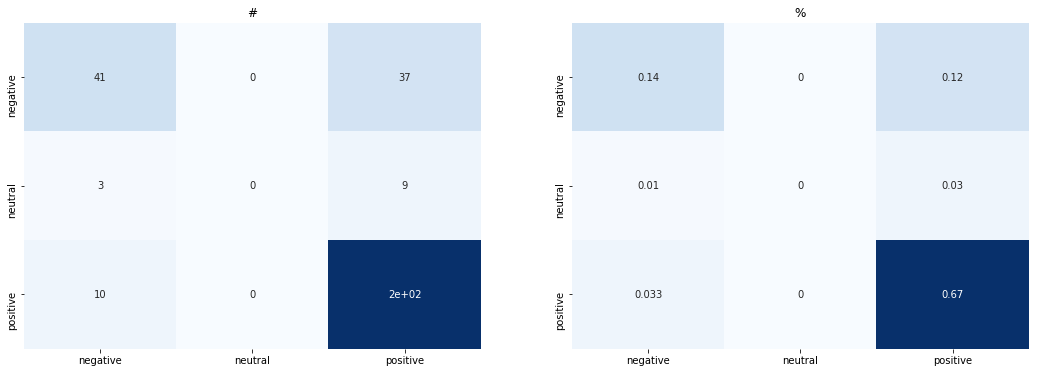

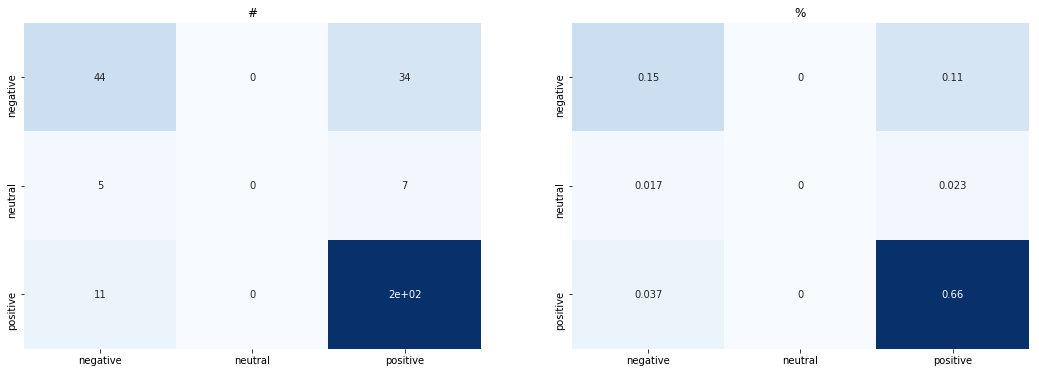

In [61]:
plot_confusion_matrix(y_test, y_predicted) # no threshold
plot_confusion_matrix(y_test, y_pred_thresh) # with thresholds

## Feature importance

In [22]:
features = pd.DataFrame({'feature':X_train.columns,
                         'coef_negative':gs.best_estimator_.coef_[0],
                         'coef_neutral':gs.best_estimator_.coef_[1],
                         'coef_positive':gs.best_estimator_.coef_[2]})
features.set_index('feature', inplace = True)
features.head()

,coef_negative,coef_neutral,coef_positive
feature,,,
length,0.951790,-0.314955,-0.636835
nb_upper,-0.019267,-0.277537,0.296805
proportion_upper,0.126263,-0.052043,-0.074220
S - absolutely,-0.287216,-0.083564,0.370780
S - amazing,-0.560246,0.250486,0.309760


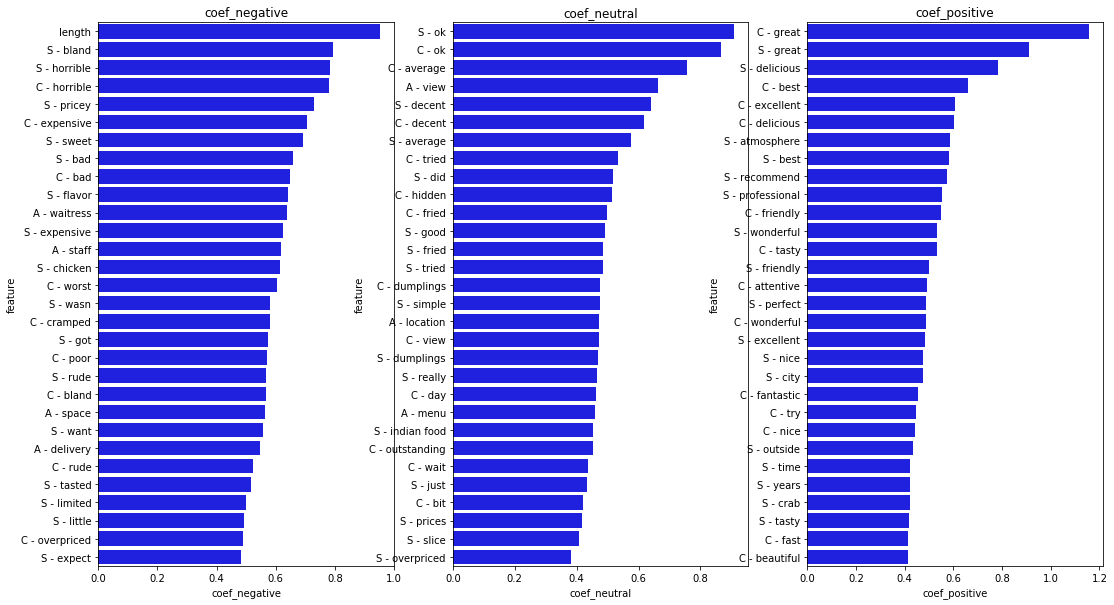

In [23]:
n = 30 # number of features to plot
plt.figure(figsize=(18,n/3))
for i, coefficient in enumerate(['coef_negative', 'coef_neutral', 'coef_positive']):
    plt.subplot(1,3,i+1)
    plt.title(coefficient)
    df_mif = features.sort_values(coefficient, ascending = False).iloc[:n][[coefficient]].reset_index()
    barplot(x=coefficient, y="feature", data=df_mif, color="b")
plt.show()

> NEXT STEPS:
> - validate results on dev set
> - transform the code in .py (+ follow the folder structure: src, data, ...)

# Annexes - Tests

## Wordcloud (no additional stop words)

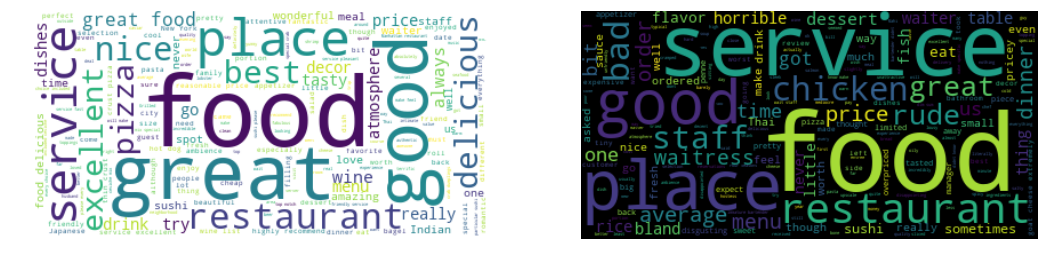

In [24]:
plt.figure(figsize = (18,6))

# Plot positive words
plt.subplot(1,2,1)
positive_words = df_train[df_train.polarity == 'positive'].sentence.sum()
cloud_positives = WordCloud(background_color='white').generate(positive_words)
plt.imshow(cloud_positives, interpolation='bilinear') 
plt.axis("off")

# Plot negative words
plt.subplot(1,2,2)
negative_words = df_train[df_train.polarity == 'negative'].sentence.sum()
cloud_negatives = WordCloud().generate(negative_words)
plt.imshow(cloud_negatives, interpolation='bilinear') 
plt.axis("off")
plt.show()

## WordCloud (with additional stop words)

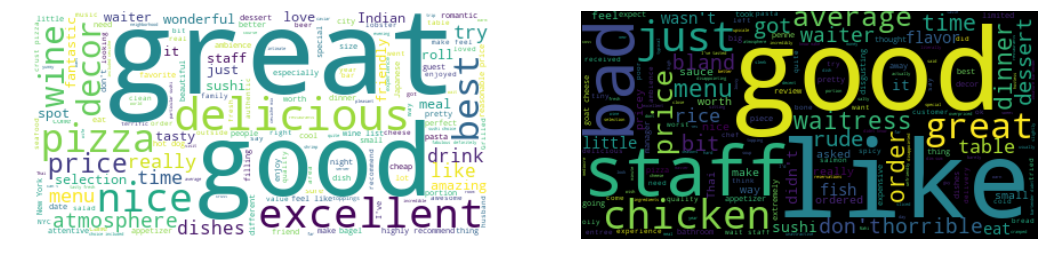

In [25]:
plt.figure(figsize = (18,6))

my_stopwords = set(ENGLISH_STOP_WORDS).union(['food', 'service', 'place', 'restaurant'])

# Plot positive words
plt.subplot(1,2,1)
positive_words = df_train[df_train.polarity == 'positive'].sentence.sum()
cloud_positives = WordCloud(background_color='white', stopwords = my_stopwords)
cloud_positives.generate(positive_words)
plt.imshow(cloud_positives, interpolation='bilinear') 
plt.axis("off")

# Plot negative words
plt.subplot(1,2,2)
negative_words = df_train[df_train.polarity == 'negative'].sentence.sum()
cloud_negatives = WordCloud(stopwords = my_stopwords)
cloud_negatives.generate(negative_words)
plt.imshow(cloud_negatives, interpolation='bilinear') 
plt.axis("off")
plt.show()

## Stemming

In [26]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

tokens = [word_tokenize(sentence) for sentence in df_train.sentence]
tokens = [[word for word in words if word.isalnum()] for words in tokens] # removing not alpha numeric words
tokens = [[word for word in words if word not in ENGLISH_STOP_WORDS] for words in tokens] # removing stop words
stemmed_tokens = [[porter.stem(word) for word in words] for words in tokens] # stemming
lemmatized_tokens = [[wnl.lemmatize(word, pos='a') for word in words] for words in tokens] # lemmatizing

print(stemmed_tokens[0])
print(lemmatized_tokens[0])

['short', 'sweet', 'seat', 'great', 'romant', 'cozi', 'privat']
['short', 'sweet', 'seating', 'great', 'romantic', 'cozy', 'private']


## POS tagging

In [27]:
# determining POS
tokens = [word_tokenize(sentence) for sentence in df_train.sentence]
POS_list = [pos_tag(sentence) for sentence in tokens]

# filter on adjective and adverb
POS_to_keep = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
tokens_adjadv = [[word for word, POS in sentence if POS in POS_to_keep] for sentence in POS_list]
tokens_adjadv = [' '.join(words) for words in tokens_adjadv]

print(tokens_adjadv[0])

short sweet great romantic cozy private


In [28]:
# Build the vectorizer
vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,1), max_features=100)
vect.fit(tokens_adjadv)
X = vect.transform(tokens_adjadv)
X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
X.head()

,absolutely,actually,amazing,atmosphere,attentive,authentic,average,away,awesome,bad,...,tasty,terrific,typical,unique,upscale,usually,warm,wine,wonderful,worth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.697475,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
y = df_train['polarity'].map({'positive':2, 'neutral':1, 'negative':0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456, stratify=y)
log_reg = LogisticRegression(solver = 'lbfgs', penalty = 'l2',
                             C = 1, multi_class = 'auto')
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)

print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_predicted))

Accuracy on train set:  0.762063227953411
Accuracy on test set:  0.7441860465116279


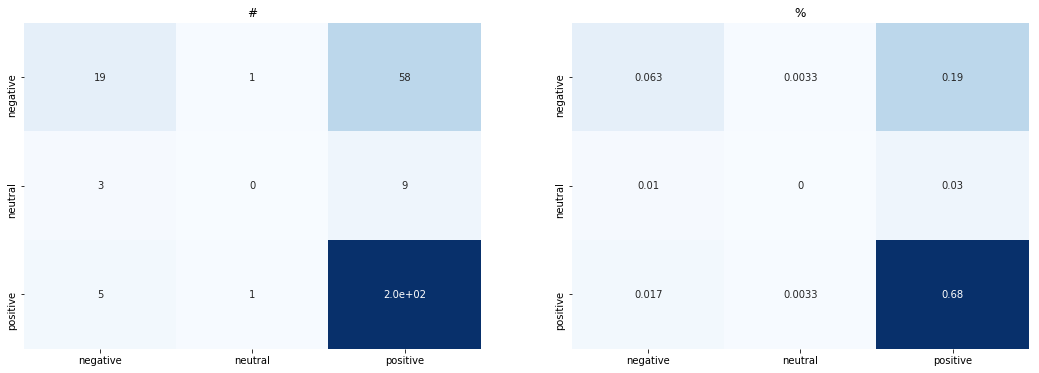

In [30]:
plt.figure(figsize = (18,6))

plt.subplot(1,2,1)
plt.title('#')
heatmap(confusion_matrix(y_test, y_predicted),
        cmap = 'Blues', annot = True, cbar = False,
        xticklabels=['negative', 'neutral', 'positive'],
        yticklabels=['negative', 'neutral', 'positive'])

plt.subplot(1,2,2)
plt.title('%')
heatmap(confusion_matrix(y_test, y_predicted)/len(y_test),
        cmap = 'Blues', annot = True, cbar = False,
        xticklabels=['negative', 'neutral', 'positive'],
        yticklabels=['negative', 'neutral', 'positive'])
plt.show()